<a href="https://colab.research.google.com/github/kcalizadeh/phil_nlp/blob/master/non_neural_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
# this cell mounts drive, sets the correct directory, then imports all functions
# and relevant libraries via the functions.py file
from google.colab import drive
import sys

# install relevent libraries not included with colab
!pip install lime
!pip install symspellpy

drive.mount('/gdrive',force_remount=True)

drive_path = '/gdrive/MyDrive/Colab_Projects/Phil_NLP'

sys.path.append(drive_path)

Mounted at /gdrive


In [60]:
from functions import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
df = pd.read_csv('/gdrive/MyDrive/Colab_Projects/Phil_NLP/phil_nlp.csv')

df.sample(5)

,Unnamed: 0,title,author,school,sentence_spacy,sentence_str,sentence_length,sentence_lowered
151835,172840,papers vol 1,lewis,analytic,"Prepositional Objects, in.","Prepositional Objects, in.",26,"prepositional objects, in."
268406,298801,the science of logic,hegel,german_idealism,Such a logic considers it its vocation to talk...,Such a logic considers it its vocation to talk...,190,such a logic considers it its vocation to talk...
2369,2885,complete works,plato,plato,"Well, if that doesn suit you, you ll have to l...","Well, if that doesn suit you, you ll have to l...",82,"well, if that doesn suit you, you ll have to l..."
317125,353277,wealth of nations,smith,capitalism,The first bounties of this kind were those gra...,The first bounties of this kind were those gra...,145,the first bounties of this kind were those gra...
27466,35675,complete works,plato,plato,His name comes from two words meaning meat and...,His name comes from two words meaning meat and...,60,his name comes from two words meaning meat and...


In [62]:
stopwords_list = stopwords.words('english') + list(string.punctuation) + ['“','”','...',"''",'’','``', "'", "‘"]
custom_stopwords = ['–', 'also', 'something', 'cf', 'thus', 'two', 'now', 'would', 'make', 'eb', 'u', 'well', 'even', 'said', 'eg', 'us',
                    'n', 'sein', 'e', 'da', 'therefore', 'however', 'would', 'thing', 'must', 'merely', 'way', 'since', 'latter', 'first',
                    'B', 'mean', 'upon', 'yet', 'cannot', 'c', 'C', 'let', 'may', 'might', "'s", 'b', 'ofthe', 'p.', '_', '-', 'eg', 'e.g.',
                    'ie', 'i.e.', 'f', 'l', "n't", 'e.g', 'i.e', '—', '--', 'hyl', 'phil', 'one'] + stopwords_list

In [7]:
smote = SMOTE()
xtrain_smote, ytrain_smote = smote.fit_resample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [63]:
x_train, x_test, y_train, y_test = train_test_split(df['sentence_str'], df['school'])

In [64]:
tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=custom_stopwords)
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [65]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [66]:
from sklearn.preprocessing import LabelEncoder

y_train_dummies = pd.get_dummies(y_train)
y_classes = y_train_dummies.idxmax(1, skipna=False)

# Instantiate the label encoder
le = LabelEncoder()

# Fit the label encoder to our label series
le.fit(list(y_classes))

# Create integer based labels Series
y_integers = le.transform(list(y_classes))

# Create dict of labels : integer representation
labels_and_integers = dict(zip(y_classes, y_integers))

from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
sample_weights = compute_sample_weight('balanced', y_integers)

class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))

y_train = y_train.apply(lambda x: labels_and_integers[x])
y_test = y_test.apply(lambda x: labels_and_integers[x])

In [67]:
labels_and_integers

{'analytic': 0,
 'aristotle': 1,
 'capitalism': 2,
 'communism': 3,
 'continental': 4,
 'empiricism': 5,
 'german_idealism': 6,
 'phenomenology': 7,
 'plato': 8,
 'rationalism': 9}

In [78]:
y_train = y_train.apply(lambda x: labels_and_integers[x])
y_test = y_test.apply(lambda x: labels_and_integers[x])

In [101]:
rus = RandomOverSampler(sampling_strategy='all')

In [102]:
x_under, y_under = rus.fit_sample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [103]:
nb_classifier_smote = MultinomialNB()
nb_classifier_smote.fit(x_under, y_under)
nb_test_smote_preds = nb_classifier_smote.predict(tf_idf_data_test)

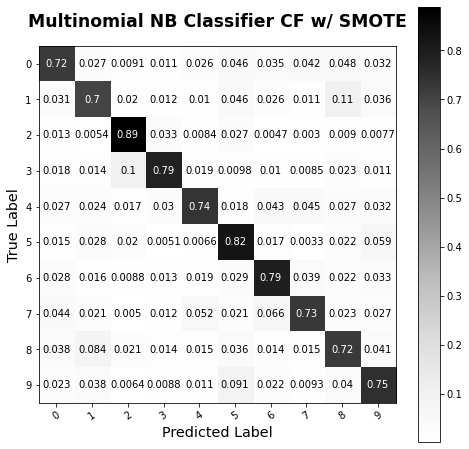

In [104]:
plot_pretty_cf(nb_classifier_smote, tf_idf_data_test, y_test, title='Multinomial NB Classifier CF w/ SMOTE')

In [105]:
print(classification_report(y_test, nb_test_smote_preds))

              precision    recall  f1-score   support

           0       0.83      0.72      0.78     13442
           1       0.81      0.70      0.75     12749
           2       0.74      0.89      0.81      4665
           3       0.76      0.79      0.77      4486
           4       0.82      0.74      0.77      8513
           5       0.60      0.82      0.69      5126
           6       0.80      0.79      0.80     10564
           7       0.75      0.73      0.74      7139
           8       0.69      0.72      0.71      9565
           9       0.63      0.75      0.69      5669

    accuracy                           0.75     81918
   macro avg       0.74      0.77      0.75     81918
weighted avg       0.76      0.75      0.75     81918



In [106]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [107]:
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

print(lemmatizer.lemmatize("I am loving it")) #I am loving it
print(lemmatizer.lemmatize("loving")) #loving
print(lemmatizer.lemmatize("loving", "v")) #love
print(lemmatize_sentence("I am loving it")) #I be love it

I am loving it
loving
love
I be love it


In [108]:
df = df.drop('Unnamed: 0', axis=1)

In [109]:
df.sample(5)

,title,author,school,sentence_spacy,sentence_str,sentence_length,sentence_lowered
132377,search after truth,malebranche,rationalism,"Finally, it follows that we do not see bodies ...","Finally, it follows that we do not see bodies ...",488,"finally, it follows that we do not see bodies ..."
2602,complete works,plato,plato,"is then the pusher (ōthoun), and so is well n...","is then the pusher (ōthoun), and so is well n...",58,"is then the pusher (ōthoun), and so is well n..."
253049,critique of judgement,kant,german_idealism,"In the genus, now as effect, now as cause, con...","In the genus, now as effect, now as cause, con...",141,"in the genus, now as effect, now as cause, con..."
78939,complete works vol 2,aristotle,aristotle,"Nor will it be found in an incomplete, but in ...","Nor will it be found in an incomplete, but in ...",65,"nor will it be found in an incomplete, but in ..."
197371,the order of things,foucault,continental,But there was a necessity lying at the heart o...,But there was a necessity lying at the heart o...,301,but there was a necessity lying at the heart o...


In [110]:
df['sentence_lemmatized'] = df['sentence_lowered'].apply(lemmatize_sentence)

In [111]:
df.sample(5)

,title,author,school,sentence_spacy,sentence_str,sentence_length,sentence_lowered,sentence_lemmatized
267798,the system of ethics,fichte,german_idealism,"Like every virtuous person, the scholar ought ...","Like every virtuous person, the scholar ought ...",75,"like every virtuous person, the scholar ought ...","like every virtuous person , the scholar ought..."
178221,philosophical troubles,kripke,analytic,The same question arises for Sherlock Holmes .,The same question arises for Sherlock Holmes .,46,the same question arises for sherlock holmes .,the same question arises for sherlock holmes .
53137,complete works vol 1,aristotle,aristotle,Some bodies are solidified by both heat and cold.,Some bodies are solidified by both heat and cold.,49,some bodies are solidified by both heat and cold.,some body be solidify by both heat and cold .
52994,complete works vol 1,aristotle,aristotle,"or non tractile, malleable or non malleable, t...","or non tractile, malleable or non malleable, t...",224,"or non tractile, malleable or non malleable, t...","or non tractile , malleable or non malleable ,..."
114928,theodicy,leibniz,rationalism,But it also for divers reasons appears likely ...,But it also for divers reasons appears likely ...,167,but it also for divers reasons appears likely ...,but it also for diver reason appear likely to ...


In [112]:
x_train, x_test, y_train, y_test = train_test_split(df['sentence_lemmatized'], df['school'])

In [113]:
tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=custom_stopwords)
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [114]:
from sklearn.preprocessing import LabelEncoder

y_train_dummies = pd.get_dummies(y_train)
y_classes = y_train_dummies.idxmax(1, skipna=False)

# Instantiate the label encoder
le = LabelEncoder()

# Fit the label encoder to our label series
le.fit(list(y_classes))

# Create integer based labels Series
y_integers = le.transform(list(y_classes))

# Create dict of labels : integer representation
labels_and_integers = dict(zip(y_classes, y_integers))

from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
sample_weights = compute_sample_weight('balanced', y_integers)

class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))

y_train = y_train.apply(lambda x: labels_and_integers[x])
y_test = y_test.apply(lambda x: labels_and_integers[x])

In [116]:
x_under, y_under = rus.fit_sample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [117]:
nb_classifier_smote = MultinomialNB()
nb_classifier_smote.fit(x_under, y_under)
nb_test_smote_preds = nb_classifier_smote.predict(tf_idf_data_test)

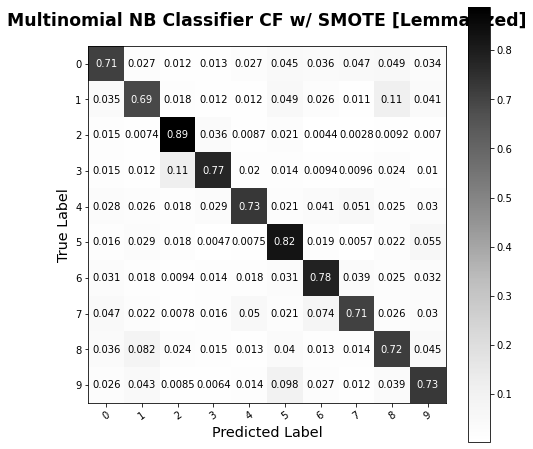

In [118]:
plot_pretty_cf(nb_classifier_smote, tf_idf_data_test, y_test, title='Multinomial NB Classifier CF w/ SMOTE [Lemmatized]')

In [119]:
print(classification_report(y_test, nb_test_smote_preds))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76     13435
           1       0.80      0.69      0.74     12640
           2       0.72      0.89      0.79      4590
           3       0.75      0.77      0.76      4593
           4       0.81      0.73      0.77      8408
           5       0.58      0.82      0.68      5058
           6       0.79      0.78      0.79     10575
           7       0.73      0.71      0.72      7182
           8       0.68      0.72      0.70      9639
           9       0.62      0.73      0.67      5798

    accuracy                           0.74     81918
   macro avg       0.73      0.75      0.74     81918
weighted avg       0.75      0.74      0.74     81918

